# Finding relaxation in the city

## New York City

### NYC Open Data

In [1]:
#Install the necessary packages
!pip install sodapy
!conda install -c conda-forge geopy --yes
!pip install seaborn

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [2]:
#Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from sodapy import Socrata
from geopy.geocoders import Nominatim
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.datasets.samples_generator import make_blobs

In [3]:
# Request the housing market data from NYC Open Data and convert json into pandas dataframe
client = Socrata("data.cityofnewyork.us", None)
results = client.get("5yay-3jd5", limit=2000)
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [4]:
#Inspect the NYC Housing Market data
results_df.head()

,average_sale_price,highest_sale_price,lowest_sale_price,median_sale_price,neighborhood,number_of_sales,total_no_of_properties,type_of_home
0,2872500,4750000,995000,2872500,CHELSEA,2,81,02 TWO FAMILY HOMES
1,3800000,3800000,3800000,3800000,CHELSEA,1,64,03 THREE FAMILY HOMES
2,7926432,7926432,7926432,7926432,EAST VILLAGE,1,22,01 ONE FAMILY HOMES
3,3892500,4700000,3085000,3892500,EAST VILLAGE,2,39,02 TWO FAMILY HOMES
4,2400000,2400000,2400000,2400000,EAST VILLAGE,1,18,03 THREE FAMILY HOMES


In [5]:
#Inspect the data types
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 8 columns):
average_sale_price        41 non-null object
highest_sale_price        41 non-null object
lowest_sale_price         41 non-null object
median_sale_price         41 non-null object
neighborhood              41 non-null object
number_of_sales           41 non-null object
total_no_of_properties    41 non-null object
type_of_home              41 non-null object
dtypes: object(8)
memory usage: 2.6+ KB


In [6]:
#Cast the type of the columns that should be numeric to integer and inspect results
numeric_columns = ['average_sale_price', 'highest_sale_price', 'lowest_sale_price', 'median_sale_price', 'number_of_sales', 'total_no_of_properties']
for column in numeric_columns:
    results_df[column] = results_df[column].astype(int)
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 8 columns):
average_sale_price        41 non-null int64
highest_sale_price        41 non-null int64
lowest_sale_price         41 non-null int64
median_sale_price         41 non-null int64
neighborhood              41 non-null object
number_of_sales           41 non-null int64
total_no_of_properties    41 non-null int64
type_of_home              41 non-null object
dtypes: int64(6), object(2)
memory usage: 2.6+ KB


In [7]:
#Extract the median sale price and the identifying columns
df = results_df[['neighborhood', 'type_of_home', 'median_sale_price']]
df.head()

,neighborhood,type_of_home,median_sale_price
0,CHELSEA,02 TWO FAMILY HOMES,2872500
1,CHELSEA,03 THREE FAMILY HOMES,3800000
2,EAST VILLAGE,01 ONE FAMILY HOMES,7926432
3,EAST VILLAGE,02 TWO FAMILY HOMES,3892500
4,EAST VILLAGE,03 THREE FAMILY HOMES,2400000


In [8]:
#We will group by neigborhood aggregating by average across type of home
df = df.pivot_table(index='neighborhood', values='median_sale_price', aggfunc=np.mean)
print(df.shape)
df.head()

(20, 1)


,median_sale_price
neighborhood,
CHELSEA,3.336250e+06
EAST VILLAGE,4.739644e+06
GRAMERCY,3.450000e+06
GREENWICH VILLAGE-CENTRAL,8.334500e+06
GREENWICH VILLAGE-WEST,5.249977e+06


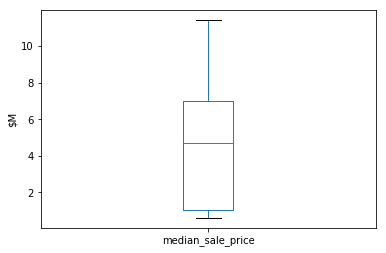

In [9]:
#Let's explore the distribution of the meadial sale prices using a boxplot
df = df/1000000
df.plot(kind='box')
plt.ylabel('$M')
plt.show()

In [10]:
df.describe()

,median_sale_price
count,20.000000
mean,4.406744
std,3.136769
min,0.594666
25%,1.013808
50%,4.714503
75%,7.015625
max,11.417500


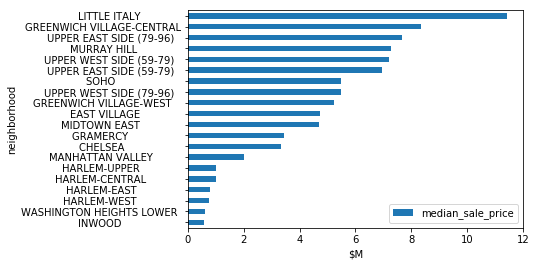

In [11]:
#Pareto analysis of the neighborhoods by sale price
df.sort_values(by='median_sale_price').plot(kind='barh')
plt.xlabel('$M')
plt.show()

In [12]:
#Test geolocator for finding latitude and longitude
geolocator = Nominatim(user_agent = 'foursquare_agent')
location = geolocator.geocode('LITTLE ITALY, NY')
lat = location.latitude
lng = location.longitude
print(lat, lng)


40.7192728 -73.9982152


In [13]:
# Get geographical coordinates for each neighborhood
geolocator = Nominatim(user_agent = 'foursquare_agent')
df['Lat'] = None
df['Lng'] = None
a = list(df.index)
for i in range(len(a)):
    location = geolocator.geocode(a[i].rstrip()+', NY')
    try:
        lat = location.latitude
        lng = location.longitude
        df.loc[a[i], 'Lat'] = lat
        df.loc[a[i], 'Lng'] = lng
    except:
      lat = None
      lng = None
        
df.head()

,median_sale_price,Lat,Lng
neighborhood,,,
CHELSEA,3.336250,40.7465,-74.0015
EAST VILLAGE,4.739644,40.7293,-73.9874
GRAMERCY,3.450000,40.7355,-73.9841
GREENWICH VILLAGE-CENTRAL,8.334500,40.732,-73.9966
GREENWICH VILLAGE-WEST,5.249977,40.732,-73.9966


In [14]:
#Are there any neighborhoods with the same geographical coordinates?
print('Total number of neighborhoods:', len(df.index))
print('Total number of neighborhoods with different coordinates:', len(df[['Lat', 'Lng']].drop_duplicates().index))

Total number of neighborhoods: 20
Total number of neighborhoods with different coordinates: 14


In [15]:
#Prepare the dataframe for cleaning the neighborhood column
df['neighborhood']=df.index
df.index=range(len(df))
df

,median_sale_price,Lat,Lng,neighborhood
0,3.336250,40.7465,-74.0015,CHELSEA
1,4.739644,40.7293,-73.9874,EAST VILLAGE
2,3.450000,40.7355,-73.9841,GRAMERCY
3,8.334500,40.732,-73.9966,GREENWICH VILLAGE-CENTRAL
4,5.249977,40.732,-73.9966,GREENWICH VILLAGE-WEST
5,0.997733,40.8079,-73.9454,HARLEM-CENTRAL
6,0.799622,40.8079,-73.9454,HARLEM-EAST
7,1.019167,40.8079,-73.9454,HARLEM-UPPER
8,0.767385,40.8079,-73.9454,HARLEM-WEST
9,0.594666,40.8693,-73.9205,INWOOD


In [16]:
#The neighborhoods containing - and () have the same geographical coordinates
#Let's standardize the neighborhood column by removing the excess characters after the - and ()
df['neighborhood']=df['neighborhood'].str.split(pat='-').str[0].str.split(pat='(').str[0]
df

,median_sale_price,Lat,Lng,neighborhood
0,3.336250,40.7465,-74.0015,CHELSEA
1,4.739644,40.7293,-73.9874,EAST VILLAGE
2,3.450000,40.7355,-73.9841,GRAMERCY
3,8.334500,40.732,-73.9966,GREENWICH VILLAGE
4,5.249977,40.732,-73.9966,GREENWICH VILLAGE
5,0.997733,40.8079,-73.9454,HARLEM
6,0.799622,40.8079,-73.9454,HARLEM
7,1.019167,40.8079,-73.9454,HARLEM
8,0.767385,40.8079,-73.9454,HARLEM
9,0.594666,40.8693,-73.9205,INWOOD


In [17]:
#Let's pivot by neighborhood, latitude and longitude
df=df.pivot_table(index=['neighborhood', 'Lat', 'Lng'])
#Reset the dataframe index
df.reset_index(level=['Lat', 'Lng'], inplace=True)
#Explore the resulting dataframe
df

,Lat,Lng,median_sale_price
neighborhood,,,
CHELSEA,40.746491,-74.001528,3.336250
EAST VILLAGE,40.729269,-73.987361,4.739644
GRAMERCY,40.735519,-73.984079,3.450000
GREENWICH VILLAGE,40.731980,-73.996566,6.792238
HARLEM,40.807879,-73.945415,0.895977
INWOOD,40.869258,-73.920495,0.594666
LITTLE ITALY,40.719273,-73.998215,11.417500
MANHATTAN VALLEY,40.799776,-73.967772,2.020000
MIDTOWN EAST,40.759822,-73.972471,4.689362


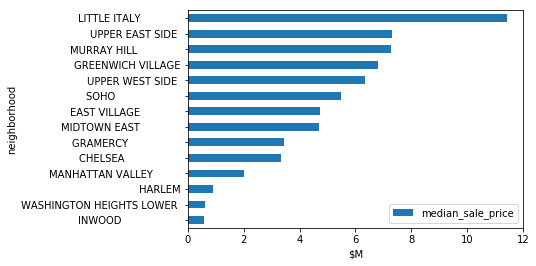

In [18]:
#With clean data now in the neighborhood column, let's pareto the neighborhoods by median sale price
df.sort_values(by='median_sale_price').plot(kind='barh', y='median_sale_price')
plt.xlabel('$M')
plt.show()

## Foursquare

The following cell is kept hidden using # @hidden_cell to ensure the Foursquare credentials remain private

In [19]:
# The code was removed by Watson Studio for sharing.

In [20]:
#Exploring the spas in Little Italy, the most expensive neighborhood
z = 'Little Italy, NY'
location = geolocator.geocode(z)
latitude = location.latitude
longitude = location.longitude
print(z,' -- Latitude:', latitude,'. Longitude', longitude)
radius = 500
search_query = 'Spa'
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()
items = results['response']['groups'][0]['items']
print(len(items))

Little Italy, NY  -- Latitude: 40.7192728 . Longitude -73.9982152
100


In [21]:
#Exploring the spas in all neighborhoods and adding them to the dataframe 
#by iterating the Foursquare requests across the dataframe
a = list(df.index)
venue = 'Spa'
df[venue] = None
for i in range(len(df)):
    latitude = df.loc[a[i], 'Lat']
    longitude = df.loc[a[i], 'Lng']
    radius_query = 500
    search_query = venue
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius_query, LIMIT)
    results = requests.get(url).json()
    items = results['response']['groups'][0]['items']
    df.loc[a[i], venue] = len(items)
df.head()

,Lat,Lng,median_sale_price,Spa
neighborhood,,,,
CHELSEA,40.746491,-74.001528,3.336250,12
EAST VILLAGE,40.729269,-73.987361,4.739644,38
GRAMERCY,40.735519,-73.984079,3.450000,42
GREENWICH VILLAGE,40.731980,-73.996566,6.792238,43
HARLEM,40.807879,-73.945415,0.895977,9


## Relationship between presence of spas and house selling prices

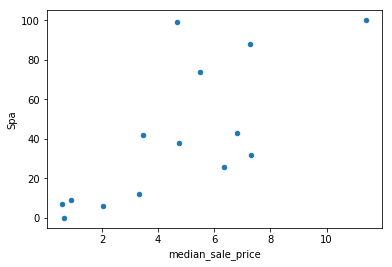

In [22]:
#Explore the relationship between median sale price and spa presence in the neighborhood with a scatter plot
df.plot(kind='scatter', x='median_sale_price', y='Spa')
plt.show()

(0, 146.15400938165197)

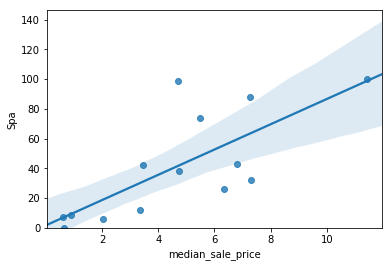

In [23]:
#Exploring linear regression using seaborn
sns.regplot(x='median_sale_price', y='Spa', data=df)
plt.ylim(0,)

In [24]:
#Explore the correlation between 'median_sale_price' and number of spas
df[['median_sale_price', 'Spa']].corr()

,median_sale_price,Spa
median_sale_price,1.00000,0.74111
Spa,0.74111,1.00000


## Relationship between presence of spas and presence of other venue types

In [27]:
#Exploring the presence of potentially related venues in all neighborhoods and adding them to the dataframe 
#by a nested iteration of the Foursquare requests across venue categores and across the neighborhoods in the dataframe
venue_categories = ['Hotel', 'Restaurant']
a = list(df.index)
for venue in venue_categories:
    df[venue] = None
    for i in range(len(df)):
        latitude = df.loc[a[i], 'Lat']
        longitude = df.loc[a[i], 'Lng']
        radius_query = 500
        search_query = venue
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius_query, LIMIT)
        results = requests.get(url).json()
        items = results['response']['groups'][0]['items']
        df.loc[a[i], venue] = len(items)

In [29]:
#Exploring the presence of potentially related venues in all neighborhoods and adding them to the dataframe 
#by a nested iteration of the Foursquare requests across venue categores and across the neighborhoods in the dataframe
venue_categories = ['Clothing Store']
a = list(df.index)
for venue in venue_categories:
    df[venue] = None
    for i in range(len(df)):
        latitude = df.loc[a[i], 'Lat']
        longitude = df.loc[a[i], 'Lng']
        radius_query = 500
        search_query = venue
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius_query, LIMIT)
        results = requests.get(url).json()
        items = results['response']['groups'][0]['items']
        df.loc[a[i], venue] = len(items)

In [30]:
#Exploring the presence of potentially related venues in all neighborhoods and adding them to the dataframe 
#by a nested iteration of the Foursquare requests across venue categores and across the neighborhoods in the dataframe
venue_categories = ['Spiritual Center']
a = list(df.index)
for venue in venue_categories:
    df[venue] = None
    for i in range(len(df)):
        latitude = df.loc[a[i], 'Lat']
        longitude = df.loc[a[i], 'Lng']
        radius_query = 500
        search_query = venue
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius_query, LIMIT)
        results = requests.get(url).json()
        items = results['response']['groups'][0]['items']
        df.loc[a[i], venue] = len(items)

In [31]:
df.head()

,Lat,Lng,median_sale_price,Spa,Hotel,Restaurant,Spiritual Center,Clothing Store
neighborhood,,,,,,,,
CHELSEA,40.746491,-74.001528,3.336250,12,12,64,15,26
EAST VILLAGE,40.729269,-73.987361,4.739644,38,16,100,25,100
GRAMERCY,40.735519,-73.984079,3.450000,42,17,100,29,35
GREENWICH VILLAGE,40.731980,-73.996566,6.792238,43,11,100,19,93
HARLEM,40.807879,-73.945415,0.895977,9,3,72,23,48


### Hotels and Spas

(0, 193.92344851065363)

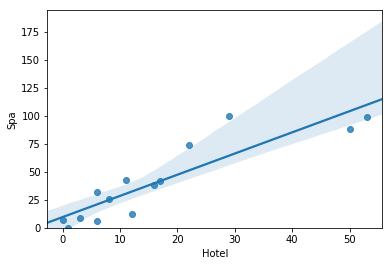

In [32]:
#Exploring linear regression using seaborn
sns.regplot(x='Hotel', y='Spa', data=df)
plt.ylim(0,)

In [33]:
#Explore the correlation between hotels and spas
df[['Hotel', 'Spa']].corr()

,Hotel,Spa
Hotel,1.000000,0.894985
Spa,0.894985,1.000000


### Restaurants and Spas

(0, 109.82468561686552)

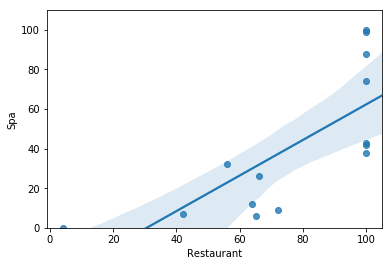

In [34]:
#Exploring linear regression using seaborn
sns.regplot(x='Restaurant', y='Spa', data=df)
plt.ylim(0,)

In [35]:
#Explore the correlation between restaurants and spas
df[['Restaurant', 'Spa']].corr()

,Restaurant,Spa
Restaurant,1.00000,0.74164
Spa,0.74164,1.00000


### Spiritual centers and Spas

(0, 105.35733430254894)

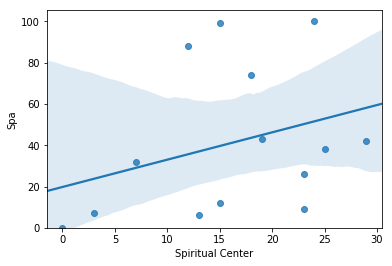

In [36]:
#Exploring linear regression using seaborn
sns.regplot(x='Spiritual Center', y='Spa', data=df)
plt.ylim(0,)

In [37]:
#Explore the correlation between spiritual centers and spas
df[['Spiritual Center', 'Spa']].corr()

,Spiritual Center,Spa
Spiritual Center,1.000000,0.319976
Spa,0.319976,1.000000


### Clothing stores and Spas

(0, 105.91368240100115)

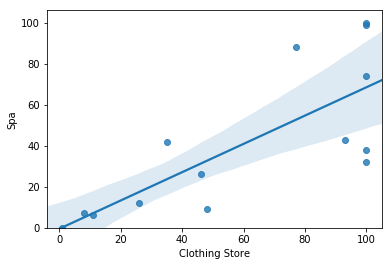

In [38]:
#Exploring linear regression using seaborn
sns.regplot(x='Clothing Store', y='Spa', data=df)
plt.ylim(0,)

In [39]:
#Explore the correlation between spiritual centers and spas
df[['Clothing Store', 'Spa']].corr()

,Clothing Store,Spa
Clothing Store,1.000000,0.762911
Spa,0.762911,1.000000


In [40]:
#Explore the correlation between all variables
df[['Spa', 'median_sale_price', 'Hotel', 'Restaurant', 'Spiritual Center', 'Clothing Store']].corr()

,Spa,median_sale_price,Hotel,Restaurant,Spiritual Center,Clothing Store
Spa,1.000000,0.741110,0.894985,0.741640,0.319976,0.762911
median_sale_price,0.741110,1.000000,0.498272,0.583710,0.360922,0.760990
Hotel,0.894985,0.498272,1.000000,0.651748,0.194226,0.562551
Restaurant,0.741640,0.583710,0.651748,1.000000,0.746727,0.720962
Spiritual Center,0.319976,0.360922,0.194226,0.746727,1.000000,0.384044
Clothing Store,0.762911,0.760990,0.562551,0.720962,0.384044,1.000000


### Multilinear regression

In [42]:
#Multilinear regression model
lm1 = LinearRegression()
Z1 = df[['median_sale_price', 'Hotel', 'Restaurant', 'Spiritual Center', 'Clothing Store']]
lm1.fit(Z1, df['Spa'])
print('Value of the intercept:', lm1.intercept_)
for parameter, coefficient in zip(Z1.columns, lm1.coef_):
    print('Coefficient for', parameter,':', coefficient)
Y1_predict_multifit = lm1.predict(Z1)
print('The Mean Square Error is:', mean_squared_error(df['Spa'], Y1_predict_multifit))
print('Te R-square is:', lm1.score(Z1, df['Spa']))

Value of the intercept: -9.667970334666997
Coefficient for median_sale_price : 3.1288361400413907
Coefficient for Hotel : 1.3257543328919803
Coefficient for Restaurant : 0.08395736097274764
Coefficient for Spiritual Center : -0.05140422980441759
Coefficient for Clothing Store : 0.14154961840968042
The Mean Square Error is: 80.34684317436192
Te R-square is: 0.9313681870939311


In [43]:
#Explore refined multilinear model by dropping the spiritual centers
lm2 = LinearRegression()
Z2 = df[['median_sale_price', 'Hotel', 'Restaurant', 'Clothing Store']]
lm2.fit(Z2, df['Spa'])
print('Value of the intercept:', lm2.intercept_)
for parameter, coefficient in zip(Z2.columns, lm2.coef_):
    print('Coefficient for', parameter,':', coefficient)
Y2_predict_multifit = lm2.predict(Z2)
print('The Mean Square Error is:', mean_squared_error(df['Spa'], Y2_predict_multifit))
print('Te R-square is:', lm2.score(Z2, df['Spa']))

Value of the intercept: -9.439482494012282
Coefficient for median_sale_price : 3.108523720898595
Coefficient for Hotel : 1.3384656214985666
Coefficient for Restaurant : 0.06563227691605635
Coefficient for Clothing Store : 0.14524103651485887
The Mean Square Error is: 80.39395046092079
Te R-square is: 0.931327948319763


In [44]:
### Find neighborhood with less spas than predicted
df['Spa_predict1']=Y1_predict_multifit
df['Potential']=round(df['Spa_predict1'] - df['Spa'],1)

In [45]:
df.head()

,Lat,Lng,median_sale_price,Spa,Hotel,Restaurant,Spiritual Center,Clothing Store,Spa_predict1,Potential
neighborhood,,,,,,,,,,
CHELSEA,40.746491,-74.001528,3.336250,12,12,64,15,26,24.962159,13.0
EAST VILLAGE,40.729269,-73.987361,4.739644,38,16,100,25,100,47.639261,9.6
GRAMERCY,40.735519,-73.984079,3.450000,42,17,100,29,35,35.523588,-6.5
GREENWICH VILLAGE,40.731980,-73.996566,6.792238,43,11,100,19,93,46.750298,3.8
HARLEM,40.807879,-73.945415,0.895977,9,3,72,23,48,8.769671,-0.2


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, CHELSEA                   to WASHINGTON HEIGHTS LOWER 
Data columns (total 10 columns):
Lat                  14 non-null float64
Lng                  14 non-null float64
median_sale_price    14 non-null float64
Spa                  14 non-null int64
Hotel                14 non-null int64
Restaurant           14 non-null int64
Spiritual Center     14 non-null int64
Clothing Store       14 non-null int64
Spa_predict1         14 non-null float64
Potential            14 non-null float64
dtypes: float64(5), int64(5)
memory usage: 1.8+ KB


In [47]:
df.sort_values(by='Potential', ascending=False, inplace=True)
df.head(10)

,Lat,Lng,median_sale_price,Spa,Hotel,Restaurant,Spiritual Center,Clothing Store,Spa_predict1,Potential
neighborhood,,,,,,,,,,
CHELSEA,40.746491,-74.001528,3.336250,12,12,64,15,26,24.962159,13.0
MURRAY HILL,40.748157,-73.978750,7.282040,88,50,100,12,77,98.082262,10.1
EAST VILLAGE,40.729269,-73.987361,4.739644,38,16,100,25,100,47.639261,9.6
UPPER EAST SIDE,40.773702,-73.964120,7.309583,32,6,56,7,100,39.653789,7.7
UPPER WEST SIDE,40.787045,-73.975416,6.342500,26,8,66,23,46,31.652879,5.7
MANHATTAN VALLEY,40.799776,-73.967772,2.020000,6,6,65,13,11,10.952824,5.0
GREENWICH VILLAGE,40.731980,-73.996566,6.792238,43,11,100,19,93,46.750298,3.8
HARLEM,40.807879,-73.945415,0.895977,9,3,72,23,48,8.769671,-0.2
MIDTOWN EAST,40.759822,-73.972471,4.689362,99,53,100,15,100,97.048888,-2.0


In [48]:
df_potential1 = df[df['Potential'] > 0]
df_potential1.head(10)

,Lat,Lng,median_sale_price,Spa,Hotel,Restaurant,Spiritual Center,Clothing Store,Spa_predict1,Potential
neighborhood,,,,,,,,,,
CHELSEA,40.746491,-74.001528,3.336250,12,12,64,15,26,24.962159,13.0
MURRAY HILL,40.748157,-73.978750,7.282040,88,50,100,12,77,98.082262,10.1
EAST VILLAGE,40.729269,-73.987361,4.739644,38,16,100,25,100,47.639261,9.6
UPPER EAST SIDE,40.773702,-73.964120,7.309583,32,6,56,7,100,39.653789,7.7
UPPER WEST SIDE,40.787045,-73.975416,6.342500,26,8,66,23,46,31.652879,5.7
MANHATTAN VALLEY,40.799776,-73.967772,2.020000,6,6,65,13,11,10.952824,5.0
GREENWICH VILLAGE,40.731980,-73.996566,6.792238,43,11,100,19,93,46.750298,3.8


# Folium

In [49]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-3.1.0               |           py36_0         724 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         822 KB

The following NEW packages will be INSTALLED:

    altair:  3.1.0-py36_0 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge


vincent-0.4.4        | 28 KB     | #################################

In [50]:
geolocator = Nominatim(user_agent = 'foursquare_agent')
location = geolocator.geocode('Manhattan, NY')
lat_NYC = location.latitude
lng_NYC = location.longitude
print(lat_NYC, lng_NYC)

40.7900869 -73.9598295


In [51]:
nyc_map = folium.Map(location=[lat_NYC, lng_NYC], zoom_start=12)
NYC_potential = folium.map.FeatureGroup()
for lat, lng, potential in zip(df_potential1.Lat, df_potential1.Lng, df_potential1.Potential):
    NYC_potential.add_child(
        folium.features.CircleMarker(
            [lat,lng],
            radius=potential,
            color='red',
            fill=True,
            fill_color='yellow',
            fill_opacity=0.4))
nyc_map.add_child(NYC_potential)
nyc_map